<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px; text-align: center;">

<h2 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Comic Sans MS">
Увоз библиотека</h2>
</div>

In [1]:
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn
from torchvision import transforms
import os

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px; text-align: center;">

<h2 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Comic Sans MS">
Учитавање скупова података</h2>
</div>

In [3]:
# Setup directory paths to train and test images
train_dir = 'EPT100/train_512'
val_dir = 'EPT100/val_512'
test_dir = 'EPT100/test_512'

In [4]:
def set_seeds(seed: int=42):
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

NUM_WORKERS = os.cpu_count()
print(NUM_WORKERS)

def create_dataloaders(train_dir: str, test_dir: str, val_dir: str, transform: transforms.Compose, batch_size: int, num_workers: int=NUM_WORKERS):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)
  val_data = datasets.ImageFolder(val_dir, transform = transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
    
  val_dataloader = DataLoader(
      val_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )
    
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, val_dataloader, test_dataloader, class_names

12


In [5]:
IMG_SIZE = 224
custom_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])
print(f"Custom created transforms: {custom_transform}")

Custom created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [6]:
BATCH_SIZE = 32
train_dataloader, val_dataloader, test_dataloader, class_names = create_dataloaders(train_dir=train_dir, test_dir=test_dir, val_dir=val_dir, transform=custom_transform, batch_size=BATCH_SIZE)

In [7]:
# Assuming you have a DataLoader named 'dataloader'
for batch in val_dataloader:
    # 'batch' is a tuple containing input data and labels
    input_data, labels = batch
    
    # Print the shape of the input data in the batch
    print("Shape of input data:", input_data.shape)
    
    # Optionally, print the shape of labels as well
    print("Shape of labels:", labels.shape)
    
    # You can break the loop if you only want to see the shape of the first batch
    break

Shape of input data: torch.Size([32, 3, 224, 224])
Shape of labels: torch.Size([32])


torch.Size([3, 224, 224]) tensor(30)


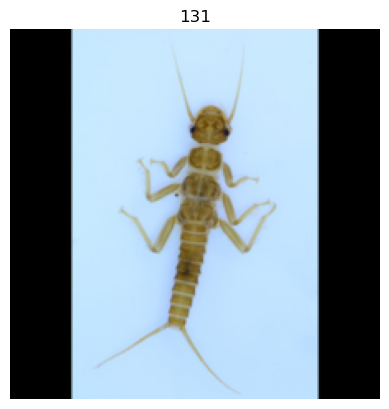

In [8]:
# Let's visualize a image in order to know if data is loaded properly or not

# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
print(image.shape, label)

# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px; text-align: center;">

  <h2 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Comic Sans MS">
    <em>Patch Embedding</em>
  </h2>
  
</div>

<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px; text-align: center;">

  <h2 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Comic Sans M    raryPatch Embeddingmport</em>
  </h2>
  
</div>


In [9]:
# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.
    
    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """ 
    # 2. Initialize the class with appropriate variables
    def __init__(self, 
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()

        self.patch_size = patch_size
        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    # 5. Define the forward method 
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % self.patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"
        
        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched) 
        
        # 6. Make sure the output shape has the right order 
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px; text-align: center;">

  <h2 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Comic Sans MS">
    <em>Multi-Head Self Attention</em>
  </h2>
  
</div>


In [10]:
# 1. Create a class that inherits from nn.Module
class MultiheadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block ("MSA block" for short).
    """
    # 2. Initialize the class with hyperparameters from Table 1
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0): # doesn't look like the paper uses any dropout in MSABlocks
        super().__init__()
        
        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        # 4. Create the Multi-Head Attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True) # does our batch dimension come first?
        
    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, # query embeddings 
                                             key=x, # key embeddings
                                             value=x, # value embeddings
                                             need_weights=False) # do we need the weights or just the layer outputs?
        return attn_output

<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px; text-align: center;">

<h2 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Comic Sans MS">
Блок вишеслојног перцептрона</h2>
</div>

In [11]:
# 1. Create a class that inherits from nn.Module
class MLPBlock(nn.Module):
    """Creates a layer normalized multilayer perceptron block ("MLP block" for short)."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden Size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 dropout:float=0.1): # Dropout from Table 3 for ViT-Base
        super().__init__()
        
        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        # 4. Create the Multilayer perceptron (MLP) layer(s)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(), # "The MLP contains two layers with a GELU non-linearity (section 3.1)."
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, # needs to take same in_features as out_features of layer above
                      out_features=embedding_dim), # take back to embedding_dim
            nn.Dropout(p=dropout) # "Dropout, when used, is applied after every dense layer.."
        )
    
    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px; text-align: center;">

<h2 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Comic Sans MS">
Трансформер енкодер</h2>
</div>

In [12]:
# 1. Create a class that inherits from nn.Module
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 mlp_dropout:float=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                 attn_dropout:float=0): # Amount of dropout for attention layers
        super().__init__()

        # 3. Create MSA block (equation 2)
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)
        
        # 4. Create MLP block (equation 3)
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)
        
    # 5. Create a forward() method  
    def forward(self, x):
        
        # 6. Create residual connection for MSA block (add the input to the output)
        x =  self.msa_block(x) + x 
        
        # 7. Create residual connection for MLP block (add the input to the output)
        x = self.mlp_block(x) + x 
        
        return x

In [13]:
transformer_encoder_block = TransformerEncoderBlock()

from torchinfo import summary
# # Print an input and output summary of our Transformer Encoder (uncomment for full output)
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
       row_settings=["var_names"])

D:\miniconda_instalacija\envs\master_rad\lib\site-packages\torch\nn\modules\activation.py:1196: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  return torch._native_multi_head_attention(


Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px; text-align: center;">

<h2 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Comic Sans MS">
Креирање визуелног трансформера</h2>
</div>

In [14]:
# 1. Create a ViT class that inherits from nn.Module
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 img_size:int=224, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0, # Dropout for attention projection
                 mlp_dropout:float=0.1, # Dropout for dense/MLP layers 
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 num_classes:int=1000): # Default for ImageNet but can customize this
        super().__init__() # don't forget the super().__init__()!
        
        # 3. Make the image size is divisble by the patch size 
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."
        
        # 4. Calculate number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2
                 
        # 5. Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)
        
        # 6. Create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)
                
        # 7. Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        
        # 8. Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
        
        # 9. Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential()) 
        # Note: The "*" means "all"
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
       
        # 10. Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, 
                      out_features=num_classes)
        )
    
    # 11. Create a forward() method
    def forward(self, x):
        
        # 12. Get batch size
        batch_size = x.shape[0]
        
        # 13. Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

        # 14. Create patch embedding (equation 1)
        x = self.patch_embedding(x)

        # 15. Concat class embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)

        # 16. Add position embedding to patch embedding (equation 1) 
        x = self.position_embedding + x

        # 17. Run embedding dropout (Appendix B.1)
        x = self.embedding_dropout(x)

        # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_encoder(x)

        # 19. Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x       

<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px; text-align: center;">

<h2 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Comic Sans MS">
Тренирање модела</h2>
</div>

In [16]:
print(len(class_names))
vit = ViT(num_classes=len(class_names))

100


In [19]:
from torchinfo import summary
# # Print an input and output summary of our Transformer Encoder (uncomment for full output)
summary(model=vit,
        input_size=(32, 3, 224, 224), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 3, 224, 224]    [32, 100]            152,064              True
├─PatchEmbedding (patch_embedding)                           [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                      [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                     [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                           [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                           [32, 197, 768]       [32, 197, 768]

In [20]:
from going_modular.going_modular import engine

# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper 
#optimizer = torch.optim.Adam(params=vit.parameters(), 
                            # lr=1e-3, # Base LR from Table 3 for ViT-* ImageNet-1k
                             #betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             #weight_decay=0.1) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

optimizer = torch.optim.SGD(vit.parameters(), 
                            lr=1e-3, 
                            momentum=0.9)
# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds
set_seeds(33)
# Train the model and save the training results to a dictionary
results, model = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       val_dataloader=val_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=100,
                       patience=20,
                       lr_patience=12,
                       best_model_path='Results/Models/best_model_implementation.pth',
                       device=device)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.1459 | train_acc: 0.0380 | val_loss: 3.8393 | val_acc: 0.0475 | learning_rate: 0.001000
Epoch: 2 | train_loss: 3.7112 | train_acc: 0.0749 | val_loss: 3.4525 | val_acc: 0.1150 | learning_rate: 0.001000
Epoch: 3 | train_loss: 3.2188 | train_acc: 0.1365 | val_loss: 2.8490 | val_acc: 0.1801 | learning_rate: 0.001000
Epoch: 4 | train_loss: 2.9188 | train_acc: 0.1610 | val_loss: 2.9065 | val_acc: 0.1760 | learning_rate: 0.001000
Epoch: 5 | train_loss: 2.8199 | train_acc: 0.1827 | val_loss: 2.7257 | val_acc: 0.2002 | learning_rate: 0.001000
Epoch: 6 | train_loss: 2.7268 | train_acc: 0.2063 | val_loss: 2.6436 | val_acc: 0.2382 | learning_rate: 0.001000
Epoch: 7 | train_loss: 2.6799 | train_acc: 0.2116 | val_loss: 2.5725 | val_acc: 0.2559 | learning_rate: 0.001000
Epoch: 8 | train_loss: 2.6388 | train_acc: 0.2209 | val_loss: 2.5108 | val_acc: 0.2574 | learning_rate: 0.001000
Epoch: 9 | train_loss: 2.5726 | train_acc: 0.2414 | val_loss: 2.5495 | val_acc: 0.2526 | learnin

In [21]:
torch.save(model, 'Results/Models/best_model_implementation.pth')

In [22]:
loaded_model = torch.load('Results/Models/best_model_implementation.pth')

# Switch the model to evaluation mode
loaded_model.eval()

ViT(
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (patch_embedding): PatchEmbedding(
    (patcher): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (flatten): Flatten(start_dim=2, end_dim=3)
  )
  (transformer_encoder): Sequential(
    (0): TransformerEncoderBlock(
      (msa_block): MultiheadSelfAttentionBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
      )
      (mlp_block): MLPBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
  

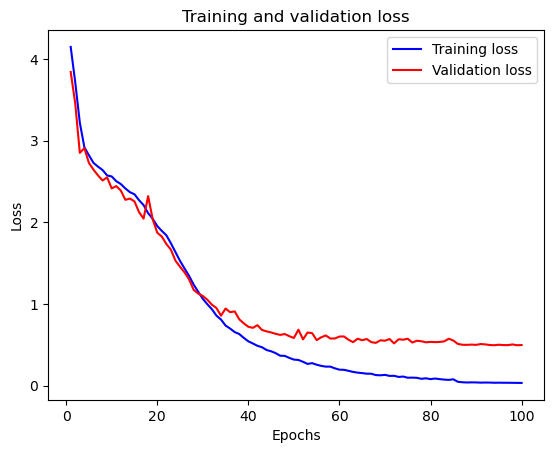

In [23]:
epochs = range(1, len(results['train_loss']) + 1)

plt.plot(epochs, results['train_loss'], 'b-', label='Training loss')
plt.plot(epochs, results['val_loss'], 'r-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

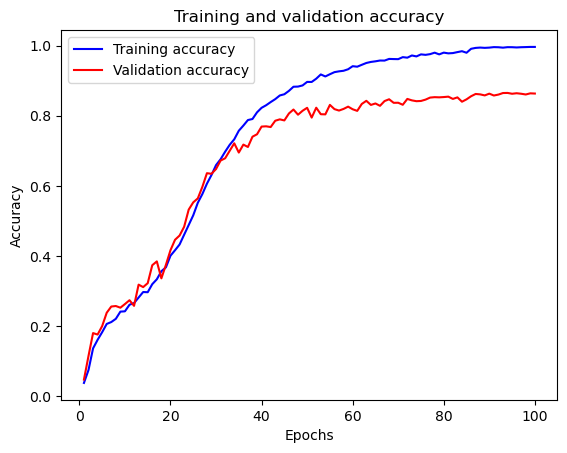

In [24]:
epochs = range(1, len(results['train_acc']) + 1)

plt.plot(epochs, results['train_acc'], 'b-', label='Training accuracy')
plt.plot(epochs, results['val_acc'], 'r-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px; text-align: center;">

<h2 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Comic Sans MS">
Тестирање модела</h2>
</div>

In [25]:
set_seeds(33)
test_loss, test_acc = engine.test(model=loaded_model,
                           test_dataloader=test_dataloader,
                           loss_fn=loss_fn,
                           device=device)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Test Loss: 0.4938, Test Accuracy: 0.8719


In [27]:
import pickle

# Save the pretrained_vit_results dictionary to disk
with open('Results/Training results/implemented_vit_results.pkl', 'wb') as f:
    pickle.dump(results, f)

In [28]:
with open('Results/Training results/implemented_vit_results.pkl', 'rb') as f:
    loaded_pretrained_vit_results = pickle.load(f)